## Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! python -m spacy download es_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 2.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
! pip install pymongo==4.3.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.9/494.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 8.2 MB/s eta 0:00:00


In [4]:
! pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 19.3 MB/s eta 0:00:00


In [5]:
!curl ipecho.net/plain

34.75.162.116

## Imports

In [6]:
import sys
sys.path.append('/content/gdrive/MyDrive/tesis/code')

In [7]:
import os
import re
import nltk
import spacy
import importlib
import pyLDAvis.gensim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim.corpora as corpora

from functools import partial
from itertools import chain
from wordcloud import WordCloud
from operator import itemgetter
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

In [8]:
import db

In [ ]:
importlib.reload(db)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'db' from '/content/gdrive/MyDrive/tesis/code/db.py'>

In [9]:
conn = db.connect_mongo_db("senate-publication", from_colab=True)

In [10]:
conn.list_collection_names()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['initiatives', 'publication', 'propositions', 'unique_publications']

In [17]:
publications_cursor = conn.unique_publications.find(
    projection=["clean_summary", "clean_state_summary", "type", "processed_text"]
  )
raw_publications_df = pd.DataFrame(publications_cursor)
raw_publications_df.head()

,_id,type,processed_text,clean_state_summary,clean_summary
0,0018ac0cd878129887392b0f49455372,proposicion,{'normalized': ' instituto nacional migració...,"- La Congreso_Union exhorta, respetuosamente, ...","- La Congreso_Union exhorta, respetuosamente, ..."
1,00235c72fe5869865b614ea03124fde2,iniciativa,{'normalized': 'riesgo daño salud población o...,Propone establecer que los riesgos o daños a l...,Propone establecer que los riesgos o daños a l...
2,0060157909fe1ded5485fcab55173969,iniciativa,{'normalized': 'magistrado instructor juicio c...,Propone establecer que el Magistrado instructo...,Propone establecer que el Magistrado instructo...
3,0082043cbeb4f1f5c52f1deeb0f24316,iniciativa,{'normalized': 'objeto ordenamiento jurídico t...,Propone establecer como objeto de este ordenam...,Propone establecer como objeto de este ordenam...
4,00a479d44f0acb53cc4be46248d056bf,proposicion,{'normalized': 'nico función pública audi...,"ÙNICO. La Congreso_Union exhorta, respetuosame...","ÙNICO. La Congreso_Union exhorta, respetuosame..."


In [18]:
publications_df = raw_publications_df.join(
    pd.json_normalize(raw_publications_df.processed_text)
).drop(
    columns="processed_text"
)
publications_df.head()

,_id,type,clean_state_summary,clean_summary,normalized,adj_noun,adj_only,noun_only
0,0018ac0cd878129887392b0f49455372,proposicion,"- La Congreso_Union exhorta, respetuosamente, ...","- La Congreso_Union exhorta, respetuosamente, ...",instituto nacional migración guardia nacio...,gobiernos [ ] ESTADO ] ] gobiernos municipios ...,colindantes colocadas texano masiva flotante f...,gobiernos [ ] ESTADO ] ] gobiernos municipios ...
1,00235c72fe5869865b614ea03124fde2,iniciativa,Propone establecer que los riesgos o daños a l...,Propone establecer que los riesgos o daños a l...,riesgo daño salud población ocasionado epidem...,riesgos daños salud población ocasionados epid...,ocasionados graves dirigidas,riesgos daños salud población epidemias parte ...
2,0060157909fe1ded5485fcab55173969,iniciativa,Propone establecer que el Magistrado instructo...,Propone establecer que el Magistrado instructo...,magistrado instructor juicio contencioso admin...,instructor juicio contencioso administrativo f...,contencioso administrativo federal oficiosa di...,instructor juicio manera acuerdo firmeza sente...
3,0082043cbeb4f1f5c52f1deeb0f24316,iniciativa,Propone establecer como objeto de este ordenam...,Propone establecer como objeto de este ordenam...,objeto ordenamiento jurídico trato justo propo...,objeto ordenamiento jurídico trato justo propo...,jurídico justo proporcional propicia plena sana,objeto ordenamiento trato condición mujer form...
4,00a479d44f0acb53cc4be46248d056bf,proposicion,"ÙNICO. La Congreso_Union exhorta, respetuosame...","ÙNICO. La Congreso_Union exhorta, respetuosame...",nico función pública auditoría superior f...,irregularidades presunto desfalco ] ocurrido 2...,presunto ocurrido,irregularidades desfalco ] 2019 2020 pérdida m...


## Exploratory analysys

In [ ]:
wordcloud = WordCloud(
    background_color="white",
    max_words=5000,
    contour_width=3,
    contour_color='steelblue',
    collocations=True
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


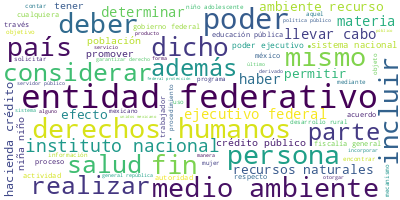

In [ ]:
long_string = " ".join(list(publications_df.normalized))
wordcloud.generate(long_string)
wordcloud.to_image()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


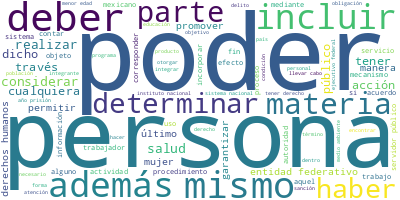

In [ ]:
long_string = " ".join(list(publications_df.loc[publications_df.type == "iniciativa"].normalized))
wordcloud.generate(long_string)
wordcloud.to_image()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


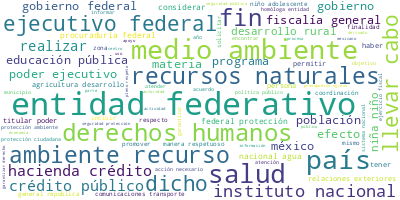

In [ ]:
long_string = " ".join(list(publications_df.loc[publications_df.type == "proposicion"].normalized))
wordcloud.generate(long_string)
wordcloud.to_image()

## Text pre-processing

In [19]:
def process_doc(text):
    """
    Clean text (create lemmas, remove special characters, remove stop words)
    """
    # remove specific words (before lemmatizing)
    for word in remove_words:
      text = text.replace(word, "")

    # remove multiple spaces
    text = re.sub(r" +", " ", text)
    text = text.strip()

    # lemmatize text
    nlp_text = nlp(text)
    lemmas = [word.lemma_ for word in nlp_text]

    normalized_text = " ".join(lemmas)

    # remove special characters
    normalized_text = normalized_text.lower()
    normalized_text = re.sub(r"[^a-záéíóúñ\d\s_]", "", normalized_text, re.A)

    # remove stopwords
    tokens = normalized_text.split(" ")
    filtered_tokens = [token for token in tokens if token not in stop_words]

    return " ".join(filtered_tokens)

In [20]:
def filter_by_pos(text, pos_tags):
    """
    keep words that match the given part of speech tags
    """
    nlp_text = nlp(text)

    # get the words for the given part of speech
    filtered_tokens = [str(word)for word in nlp_text if word.pos_ in pos_tags]

    return " ".join(filtered_tokens)

In [21]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
nlp = spacy.load("es_core_news_lg")
stop_words = nltk.corpus.stopwords.words("spanish")

In [23]:
replacements = [
    {"replacement_regex": r"(honorables? )?C[aá]maras? de Senador[ae]s( y Senador[ae]s)?", "replacement": "Camara_Senadores"},
    {"replacement_regex": r"(Comisión Permanente del |Cámaras del |Honorable )?Congreso de la Unión", "replacement": "Congreso_Union"},
    {"replacement_regex": r"Senado de la República", "replacement": "Senado_Republica"},
    {"replacement_regex": r"Secretaría de", "replacement": ""},
    {"replacement_regex": r"(esta|una) soberanía", "replacement": "[AUTORIDAD]"},
    {"replacement_regex": r"(honorables? )?C[aá]maras? de Diputad[ao]s( y Diputad[ao]s)?", "replacement": "Camara_Diputados"},
    {"replacement_regex": r"(honorables? )?C[aá]maras? de Senador[ae]s( y Senador[ae]s)?", "replacement": "Camara_Senadores"},
    {"replacement_regex": r"(Comisión Permanente del |Cámaras del )?(H\. |Honorable )?Congreso de la Unión", "replacement": "Congreso_Union"},
    {"replacement_regex": r"Senado de la Rep[uú]blica", "replacement": "Senado_Republica"},
    {"replacement_regex": r"Secretarías? de", "replacement": ""},
    {"replacement_regex": r"([Ee]xhortar?|EXHORTA|exhorto|[Ss]olicit[oa]) [Rr]espetuosamente", "replacement": ""},
    {"replacement_regex": r"(esta|una) ([Hh]onorable |H\. )?[sS]oberanía", "replacement": "[AUTORIDAD]"},
    {"replacement_regex": r"(honorables? )?C[aá]maras? de Diputad[ao]s( y Diputad[ao]s)?", "replacement": "Camara_Diputados"},
    {"replacement_regex": r"Diario Oficial de la Federación", "replacement": "DoF"},
    {"replacement_regex": r"([ÚU]NICO|PRIMERO|SEGUNDO|TERCERO|CUARTO|QUINTO)\.", "replacement": ""},
    {"replacement_regex": r"plazo (no mayor |que no exceda )?(de|a) .*? días hábiles", "replacement": "[PLAZO_ENTREGA]"},
    {"replacement_regex": r"(t[eé]rmino|periodo) de .*? días hábiles", "replacement": "[PLAZO_ENTREGA]"},

]

remove_words = set(x["replacement"] for x in replacements if x["replacement"] != "")
remove_words.add("[MUNICIPIO]")
remove_words.add("[ESTADO]")
remove_words

{'Camara_Diputados',
 'Camara_Senadores',
 'Congreso_Union',
 'DoF',
 'Senado_Republica',
 '[AUTORIDAD]',
 '[ESTADO]',
 '[MUNICIPIO]',
 '[PLAZO_ENTREGA]'}

In [24]:
new_stop_words = [
    "proponer", "exhortar", "comisión", "ser", "congreso", "ley", "establecer",
    "permanente", "respetuosamente", "unión", "caso", "así", "correspondiente",
    "reformar", "artículo", "establecer", "informe", "ámbito"
]

In [25]:
stop_words.extend(new_stop_words)

In [27]:
# create vectorized version of function
process_corpus = np.vectorize(process_doc)
extract_adj_only = np.vectorize(partial(filter_by_pos, pos_tags=["ADJ"]))
extract_noun_only = np.vectorize(partial(filter_by_pos, pos_tags=["NOUN"]))
extract_adj_noun = np.vectorize(partial(filter_by_pos, pos_tags=["ADJ", "NOUN"]))

In [ ]:
# get normalized version of the summary
publications_df["normalized"] = process_corpus(publications_df.clean_state_summary)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
text_cols = ["normalized"]
publications_df["processed_text"] = publications_df.apply(
    lambda row: {col: row[col] for col in text_cols}, axis=1
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
update_data = publications_df[["_id", "processed_text"]].to_dict(orient="records")
db.batch_update_records(
    update_data,
    "unique_publications",
    conn,
    dict_columns=["processed_text"],
    array_columns={"topics_distribution": "model_id"}
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
publications_df["adj_only"] = extract_adj_only(publications_df.normalized)
publications_df["noun_only"] = extract_noun_only(publications_df.normalized)
publications_df["adj_noun"] = extract_adj_noun(publications_df.normalized)

In [29]:
text_cols = ["adj_only", "noun_only", "adj_noun"]
publications_df["processed_text"] = publications_df.apply(
    lambda row: {col: row[col] for col in text_cols}, axis=1
)

In [31]:
update_data = publications_df[["_id", "processed_text"]].to_dict(orient="records")
db.batch_update_records(
    update_data,
    "unique_publications",
    conn,
    dict_columns=["processed_text"],
    array_columns={"topics_distribution": "model_id"}
)

## Create LDA model

In [32]:
min_topics = 3
max_topics = 15
step_size = 3
TOPICS_RANGE = range(min_topics, max_topics+1, step_size)

TEXT_TYPES = [
    "normalized", "noun_only", "adj_noun",
]
TYPE_FILTERS = ["all", "iniciativa", "proposicion"]


BASE_PATH = "/content/gdrive/MyDrive/tesis/senate_models_v2"
IMAGES_PATH = f"{BASE_PATH}/coherence_scores"
MODELS_PATH = f"{BASE_PATH}/models"
TOPICS_PATH = f"{BASE_PATH}/topics"

if not os.path.exists(IMAGES_PATH):
      os.makedirs(IMAGES_PATH)

if not os.path.exists(MODELS_PATH):
      os.makedirs(MODELS_PATH)

In [33]:
def build_lda_models(publications_df, text_type: str, filter_type: str = "all"):
  model_id = f"{text_type}_{filter_type}"

  if filter_type != "all":
    model_data = publications_df.loc[publications_df.type == filter_type]
  else:
    model_data = publications_df
  publications_words = list(model_data[text_type].apply(str.split))

  # dictionary of words
  dictionary = corpora.Dictionary(publications_words)

  # corpus with bag of words
  corpus = [dictionary.doc2bow(publication) for publication in publications_words]

  model_topics = {}
  coherence_scores = []
  for num_topics in TOPICS_RANGE:
    print(num_topics, end=", ")

    # create folder where the model will be saved
    model_dir = f"{MODELS_PATH}/{model_id}/{num_topics}_topics"
    if not os.path.exists(model_dir):
      os.makedirs(model_dir)

    model_path = f"{model_dir}/lda"
    if os.path.exists(model_path):
      # load existing lda model
      model = LdaModel.load(model_path)
    else:
      # create lda model
      model = LdaModel(
          corpus,
          num_topics=num_topics,
          id2word=dictionary,
          passes=300
      )

      # save model to drive
      model.save(model_path)

    # save topics
    model_topics[num_topics] = model.print_topics(num_topics=num_topics, num_words=10)

    # calculate coherence score
    cm = CoherenceModel(model=model, texts=publications_words, dictionary=dictionary, coherence='c_v')
    coherence_lda = cm.get_coherence()
    coherence_scores.append(coherence_lda)

  # get the num of topics with the max coherence score
  optimal_num_topics = TOPICS_RANGE[np.argmax(coherence_scores)]
  print("\nOptimal number of topics:", optimal_num_topics)
  print("Coherence Score for optimal number of topics:", max(coherence_scores))

  # print best topics
  print("")
  for topic in model_topics[optimal_num_topics]:
    print(topic)
  print("")

  # Plotting the relationship between the number of topics and coherence score
  plt.figure(figsize=(10, 6))
  plt.plot(TOPICS_RANGE, coherence_scores, marker='o')
  plt.xlabel('Number of Topics')
  plt.ylabel('Coherence Score')
  plt.title('Number of Topics vs Coherence Score')
  plt.xticks(TOPICS_RANGE)
  plt.grid(True)
  plt.savefig(f"{IMAGES_PATH}/{model_id}.png", format="png", dpi=300)
  plt.show()

  return coherence_scores

normalized – all
3, 6, 9, 12, 15, 
Optimal number of topics: 15
Coherence Score for optimal number of topics: 0.5306725889563119

(0, '0.037*"delito" + 0.022*"año" + 0.017*"persona" + 0.016*"pena" + 0.016*"público" + 0.015*"prisión" + 0.014*"cualquiera" + 0.012*"medida" + 0.011*"cometer" + 0.011*"penal"')
(1, '0.028*"unidos" + 0.028*"constitución" + 0.024*"mexicanos" + 0.024*"política" + 0.020*"constitucional" + 0.020*"iniciativa" + 0.017*"reforma" + 0.017*"general" + 0.014*"fracción" + 0.014*"decreto"')
(2, '0.044*"ambiente" + 0.040*"medio" + 0.026*"naturales" + 0.023*"recursos" + 0.015*"ambiental" + 0.014*"protección" + 0.012*"uso" + 0.011*"acción" + 0.011*"desarrollo" + 0.010*"área"')
(3, '0.068*"salud" + 0.020*"atención" + 0.019*"entidad" + 0.017*"federativo" + 0.016*"prevención" + 0.015*"acción" + 0.014*"nacional" + 0.012*"instituto" + 0.011*"campaña" + 0.011*"federal"')
(4, '0.020*"trabajo" + 0.018*"trabajador" + 0.014*"poder" + 0.012*"deber" + 0.011*"laboral" + 0.009*"producto" 

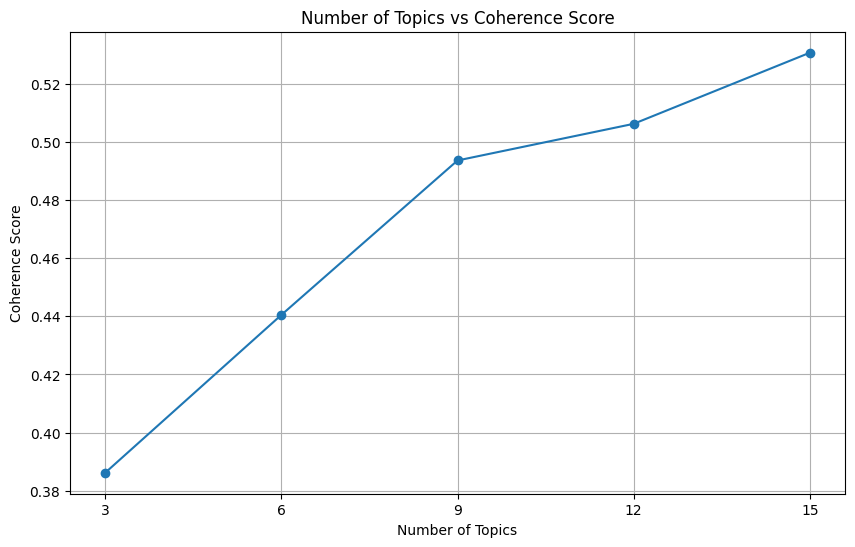

normalized – iniciativa
3, 6, 9, 12, 15, 
Optimal number of topics: 15
Coherence Score for optimal number of topics: 0.5646779557589465

(0, '0.022*"servicio" + 0.020*"deber" + 0.016*"persona" + 0.014*"información" + 0.014*"poder" + 0.012*"medio" + 0.011*"público" + 0.009*"uso" + 0.009*"cualquiera" + 0.009*"través"')
(1, '0.033*"trabajo" + 0.032*"trabajador" + 0.029*"persona" + 0.020*"poder" + 0.020*"laboral" + 0.017*"social" + 0.012*"deber" + 0.012*"seguro" + 0.012*"derecho" + 0.011*"servicio"')
(2, '0.052*"género" + 0.051*"mujer" + 0.030*"principio" + 0.023*"violencia" + 0.019*"paridad" + 0.018*"menor" + 0.015*"hijo" + 0.015*"igualdad" + 0.014*"persona" + 0.013*"edad"')
(3, '0.034*"producto" + 0.028*"agua" + 0.028*"uso" + 0.023*"consumo" + 0.014*"migratorio" + 0.014*"concesión" + 0.011*"protección" + 0.011*"disposición" + 0.011*"nacional" + 0.010*"cannabis"')
(4, '0.023*"electoral" + 0.021*"político" + 0.017*"integrante" + 0.017*"consejo" + 0.016*"nacional" + 0.014*"instituto" + 0.01

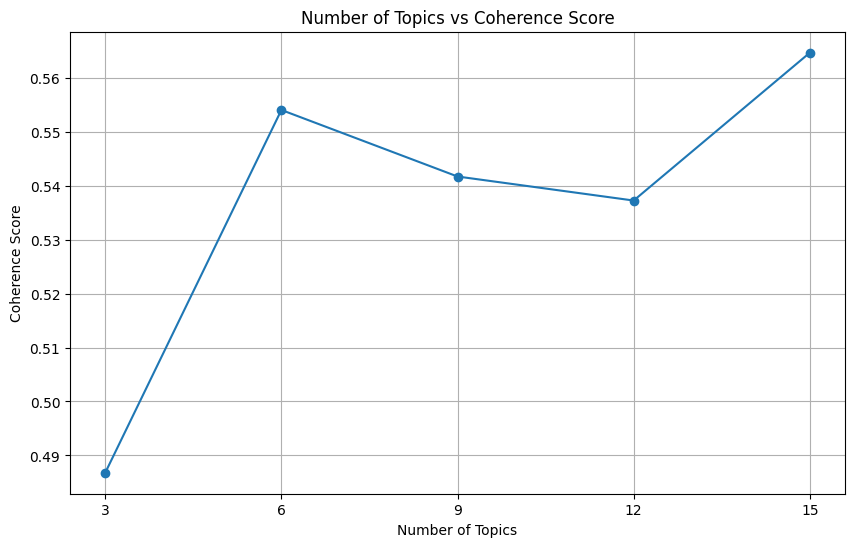

normalized – proposicion
3, 6, 9, 12, 15, 
Optimal number of topics: 12
Coherence Score for optimal number of topics: 0.5597012728337125

(0, '0.037*"nacional" + 0.035*"derechos" + 0.035*"humanos" + 0.024*"protección" + 0.018*"persona" + 0.016*"seguridad" + 0.013*"instituto" + 0.013*"migrant" + 0.010*"garantizar" + 0.009*"migración"')
(1, '0.024*"entidad" + 0.023*"federativo" + 0.022*"salud" + 0.019*"educación" + 0.016*"nacional" + 0.013*"32" + 0.013*"prevención" + 0.012*"campaña" + 0.011*"pública" + 0.011*"acción"')
(2, '0.029*"ambiente" + 0.027*"agua" + 0.023*"medio" + 0.020*"naturales" + 0.017*"nacional" + 0.017*"recursos" + 0.015*"protección" + 0.015*"acción" + 0.011*"federal" + 0.010*"gobierno"')
(3, '0.030*"público" + 0.024*"recurso" + 0.018*"crédito" + 0.017*"presupuesto" + 0.017*"hacienda" + 0.017*"programa" + 0.017*"ejercicio" + 0.014*"nacional" + 0.014*"fiscal" + 0.012*"federación"')
(4, '0.050*"desarrollo" + 0.040*"rural" + 0.035*"agricultura" + 0.017*"pesca" + 0.016*"produc

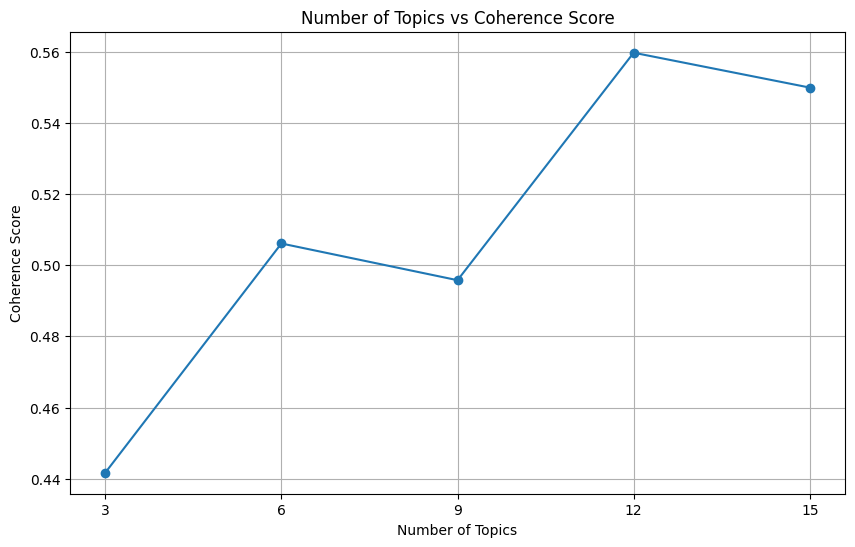

noun_only – all
3, 6, 9, 12, 15, 
Optimal number of topics: 6
Coherence Score for optimal number of topics: 0.5910058608600761

(0, '0.043*"salud" + 0.029*"atención" + 0.025*"educación" + 0.024*"derechos" + 0.022*"humanos" + 0.015*"persona" + 0.015*"programa" + 0.015*"entidad" + 0.015*"acción" + 0.014*"niña"')
(1, '0.046*"persona" + 0.031*"delito" + 0.025*"año" + 0.016*"derecho" + 0.015*"género" + 0.012*"parte" + 0.012*"pena" + 0.012*"prisión" + 0.011*"día" + 0.011*"principio"')
(2, '0.026*"desarrollo" + 0.026*"programa" + 0.024*"recurso" + 0.020*"agua" + 0.017*"servicio" + 0.017*"crédito" + 0.013*"presupuesto" + 0.012*"ejercicio" + 0.011*"sector" + 0.009*"federación"')
(3, '0.022*"día" + 0.016*"año" + 0.014*"poder" + 0.012*"acuerdo" + 0.012*"parte" + 0.011*"plazo" + 0.011*"presidente" + 0.011*"procedimiento" + 0.009*"proceso" + 0.009*"disposición"')
(4, '0.037*"ambiente" + 0.024*"recursos" + 0.020*"producto" + 0.017*"procuraduría" + 0.016*"uso" + 0.015*"acción" + 0.015*"medio" + 0.011

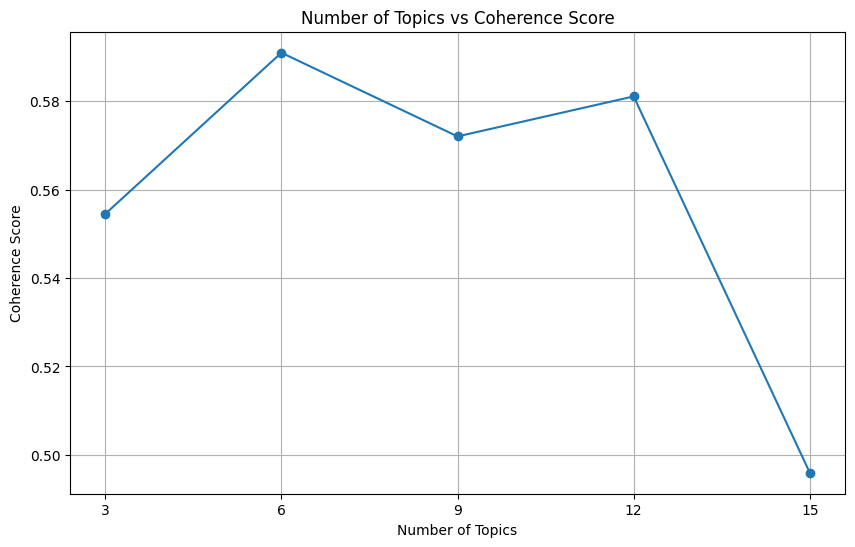

noun_only – iniciativa
3, 6, 9, 12, 15, 
Optimal number of topics: 9
Coherence Score for optimal number of topics: 0.5646448569229499

(0, '0.037*"desarrollo" + 0.036*"derecho" + 0.027*"persona" + 0.016*"materia" + 0.015*"información" + 0.014*"programa" + 0.013*"objetivo" + 0.013*"discapacidad" + 0.012*"objeto" + 0.011*"mecanismo"')
(1, '0.067*"delito" + 0.061*"año" + 0.037*"pena" + 0.036*"persona" + 0.036*"prisión" + 0.025*"día" + 0.024*"multa" + 0.019*"sanción" + 0.017*"acto" + 0.013*"edad"')
(2, '0.037*"producto" + 0.032*"uso" + 0.024*"ambiente" + 0.019*"salud" + 0.019*"agua" + 0.017*"consumo" + 0.014*"norma" + 0.013*"actividad" + 0.012*"manejo" + 0.011*"riesgo"')
(3, '0.029*"género" + 0.026*"principio" + 0.025*"cargo" + 0.024*"persona" + 0.023*"paridad" + 0.020*"órgano" + 0.015*"poder" + 0.013*"organismo" + 0.013*"función" + 0.013*"materia"')
(4, '0.052*"mujer" + 0.036*"derechos" + 0.033*"humanos" + 0.031*"persona" + 0.026*"violencia" + 0.020*"niña" + 0.020*"género" + 0.019*"niño" 

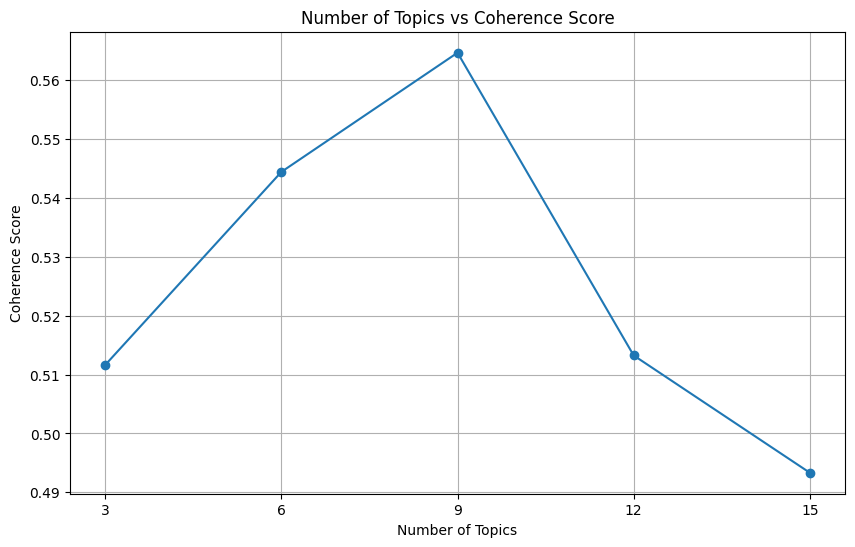

noun_only – proposicion
3, 6, 9, 12, 15, 
Optimal number of topics: 3
Coherence Score for optimal number of topics: 0.49298807554156027

(0, '0.025*"agua" + 0.025*"ambiente" + 0.018*"recursos" + 0.018*"acción" + 0.015*"desarrollo" + 0.011*"manera" + 0.011*"procuraduría" + 0.010*"atribución" + 0.010*"programa" + 0.009*"fin"')
(1, '0.018*"derechos" + 0.017*"humanos" + 0.013*"persona" + 0.011*"poder" + 0.010*"proceso" + 0.010*"fiscalía" + 0.010*"titular" + 0.009*"investigación" + 0.008*"fin" + 0.008*"materia"')
(2, '0.031*"salud" + 0.029*"entidad" + 0.021*"acción" + 0.021*"seguridad" + 0.018*"programa" + 0.015*"atención" + 0.013*"educación" + 0.012*"protección" + 0.012*"prevención" + 0.012*"fin"')



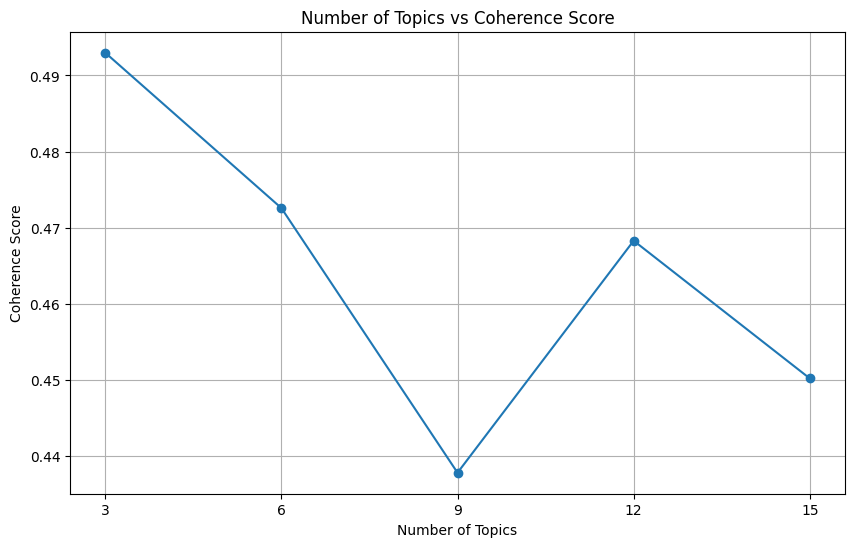

adj_noun – all
3, 6, 9, 12, 15, 
Optimal number of topics: 6
Coherence Score for optimal number of topics: 0.5428934621864853

(0, '0.029*"salud" + 0.020*"nacional" + 0.019*"educación" + 0.017*"programa" + 0.014*"entidad" + 0.014*"atención" + 0.012*"social" + 0.012*"federativo" + 0.011*"acción" + 0.010*"prevención"')
(1, '0.021*"delito" + 0.018*"persona" + 0.017*"humanos" + 0.017*"nacional" + 0.016*"derechos" + 0.016*"seguridad" + 0.015*"violencia" + 0.012*"protección" + 0.012*"mujer" + 0.012*"público"')
(2, '0.017*"público" + 0.016*"federal" + 0.015*"poder" + 0.014*"titular" + 0.013*"recurso" + 0.012*"presupuesto" + 0.012*"día" + 0.012*"ejecutivo" + 0.012*"fiscal" + 0.011*"ejercicio"')
(3, '0.017*"nacional" + 0.015*"electoral" + 0.014*"federal" + 0.013*"principio" + 0.012*"energía" + 0.010*"político" + 0.010*"género" + 0.010*"público" + 0.009*"parte" + 0.009*"integrante"')
(4, '0.020*"nacional" + 0.017*"ambiente" + 0.016*"agua" + 0.014*"federal" + 0.012*"desarrollo" + 0.012*"acción" +

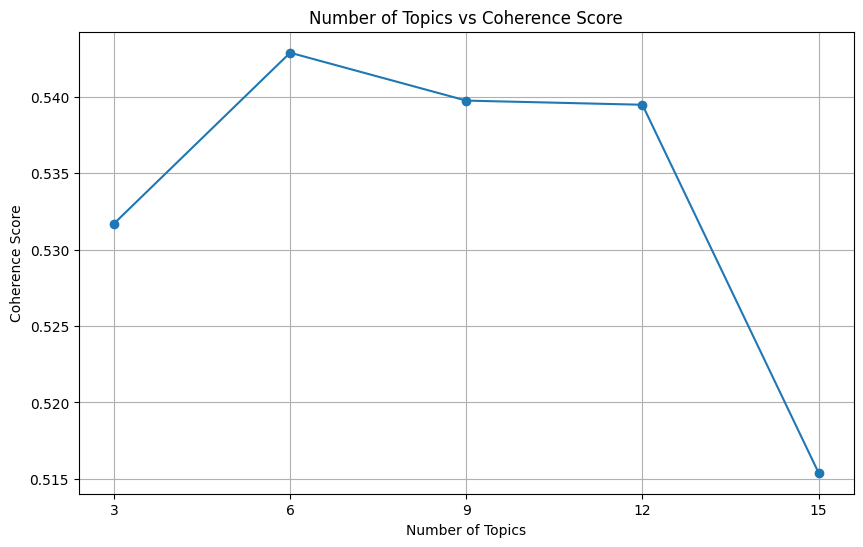

adj_noun – iniciativa
3, 6, 9, 12, 15, 
Optimal number of topics: 6
Coherence Score for optimal number of topics: 0.5435312632431741

(0, '0.032*"persona" + 0.029*"delito" + 0.021*"año" + 0.016*"trabajador" + 0.013*"día" + 0.013*"pena" + 0.013*"público" + 0.012*"prisión" + 0.012*"derecho" + 0.010*"laboral"')
(1, '0.027*"nacional" + 0.016*"público" + 0.015*"desarrollo" + 0.012*"programa" + 0.012*"social" + 0.012*"materia" + 0.011*"federal" + 0.011*"entidad" + 0.010*"política" + 0.009*"recurso"')
(2, '0.015*"uso" + 0.014*"producto" + 0.012*"servicio" + 0.010*"energía" + 0.008*"natural" + 0.007*"electrónico" + 0.007*"disposición" + 0.007*"residuo" + 0.007*"ambiente" + 0.006*"consumidor"')
(3, '0.033*"salud" + 0.018*"sanitario" + 0.017*"emergencia" + 0.015*"médico" + 0.014*"enfermedad" + 0.012*"atención" + 0.011*"general" + 0.011*"tratamiento" + 0.008*"prevención" + 0.007*"medicamento"')
(4, '0.024*"educación" + 0.018*"derecho" + 0.017*"mujer" + 0.017*"persona" + 0.015*"nacional" + 0.013*"

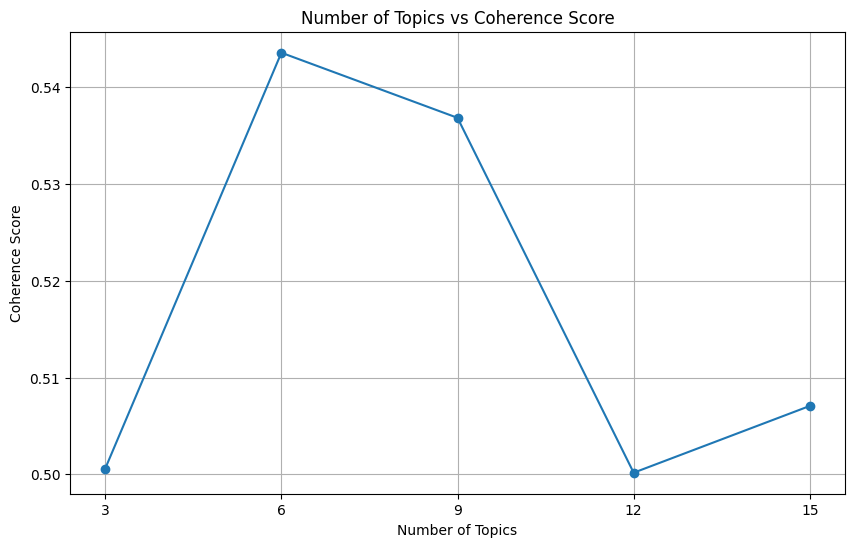

adj_noun – proposicion
3, 6, 9, 12, 15, 
Optimal number of topics: 12
Coherence Score for optimal number of topics: 0.48959510680268176

(0, '0.074*"educación" + 0.041*"pública" + 0.022*"educativo" + 0.014*"escolar" + 0.012*"programa" + 0.012*"superior" + 0.011*"básico" + 0.011*"nacional" + 0.009*"texto" + 0.009*"discapacidad"')
(1, '0.048*"titular" + 0.036*"ejecutivo" + 0.029*"federal" + 0.021*"poder" + 0.017*"seguridad" + 0.016*"acción" + 0.015*"público" + 0.013*"entidad" + 0.012*"materia" + 0.012*"política"')
(2, '0.039*"entidad" + 0.038*"seguridad" + 0.033*"nacional" + 0.032*"protección" + 0.029*"persona" + 0.026*"federativo" + 0.019*"adolescente" + 0.018*"acción" + 0.018*"niña" + 0.017*"niño"')
(3, '0.026*"federal" + 0.022*"energía" + 0.022*"comunicaciones" + 0.020*"transportes" + 0.020*"infraestructura" + 0.017*"eléctrico" + 0.015*"transporte" + 0.014*"electricidad" + 0.012*"tarifa" + 0.011*"público"')
(4, '0.030*"exhorto" + 0.019*"atento" + 0.015*"federales" + 0.013*"caminos" + 

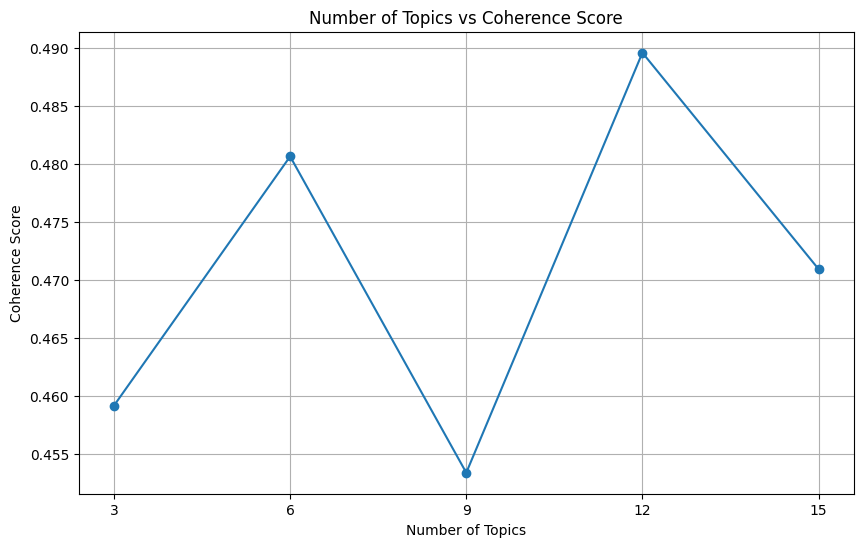

In [34]:
texts_cocherence_score = {}
for text_type in TEXT_TYPES:
  for filter in TYPE_FILTERS:
    print(f"{text_type} – {filter}")

    coherence_scores = build_lda_models(publications_df, text_type, filter)

    if filter in texts_cocherence_score:
      texts_cocherence_score[filter][text_type] = coherence_scores
    else:
      texts_cocherence_score[filter] = {
          text_type: coherence_scores
      }

    print("======="*20)

## Compare topics

In [35]:
texts_cocherence_score.keys()

dict_keys(['all', 'iniciativa', 'proposicion'])

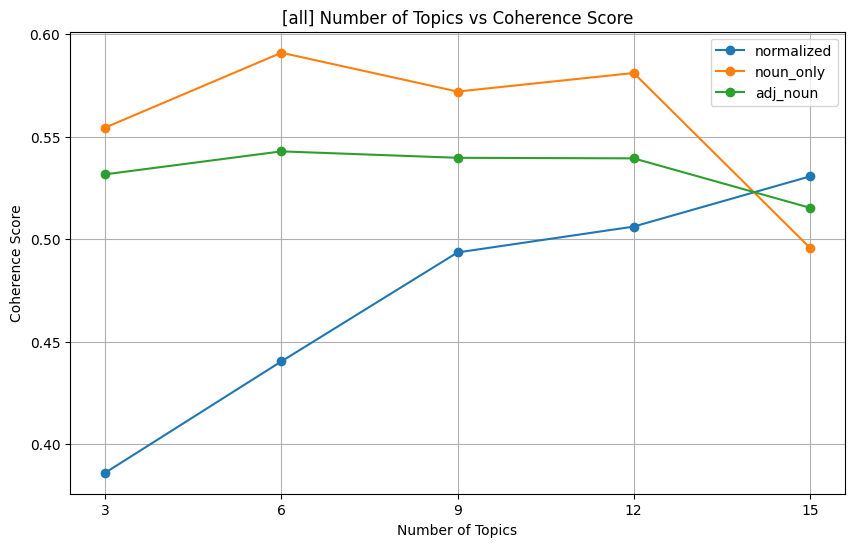

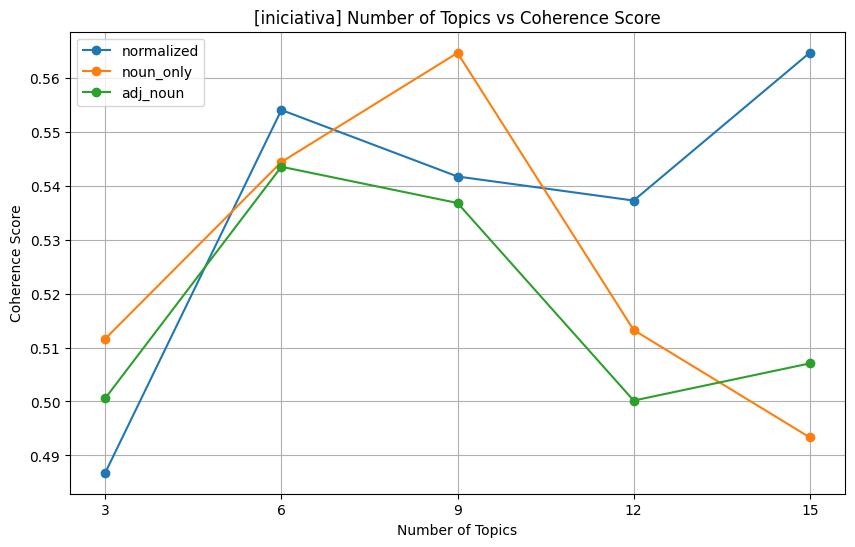

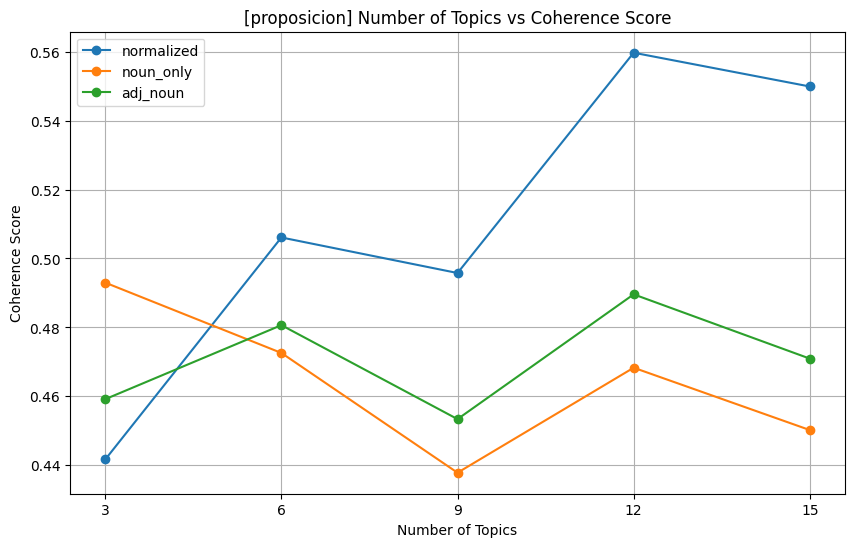

In [36]:
# plot the relationship between the number of topics and coherence score for all text types
best_scores = {}
for filter in texts_cocherence_score:
  plt.figure(figsize=(10, 6))

  max_scores = []
  for text_type, coherence_scores in texts_cocherence_score[filter].items():
    max_scores.append((text_type, max(coherence_scores)))
    plt.plot(TOPICS_RANGE, coherence_scores, marker='o', label=text_type)

  best_score_type, _ = max(max_scores, key=itemgetter(1))
  best_scores[f"{filter}_{best_score_type}"] = texts_cocherence_score[filter][best_score_type]

  plt.xlabel('Number of Topics')
  plt.ylabel('Coherence Score')
  plt.title(f'[{filter}] Number of Topics vs Coherence Score')
  plt.xticks(TOPICS_RANGE)
  plt.legend()
  plt.grid(True)
  plt.savefig(f"{BASE_PATH}/coherence_scores/compare_{filter}.png", format="png", dpi=300)
  plt.show()

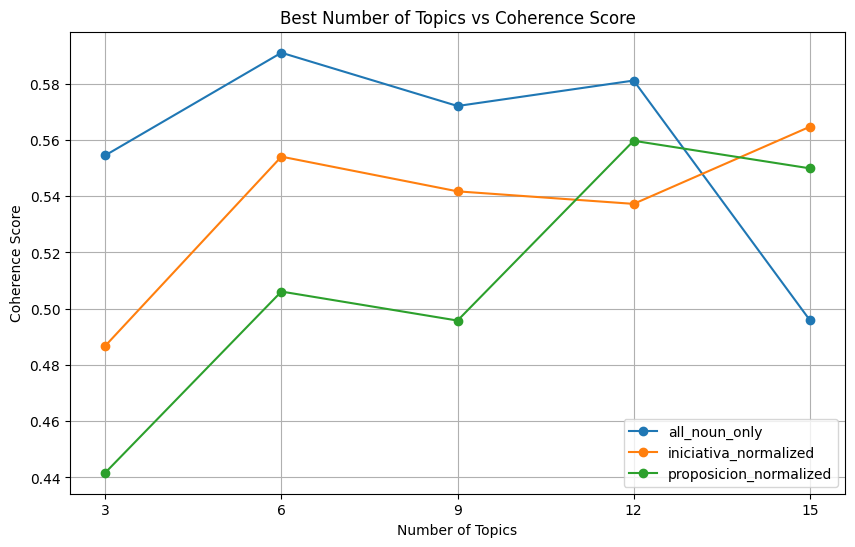

In [37]:
plt.figure(figsize=(10, 6))

for text_type, coherence_scores in best_scores.items():
  plt.plot(TOPICS_RANGE, coherence_scores, marker='o', label=text_type)

plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title(f'Best Number of Topics vs Coherence Score')
plt.xticks(TOPICS_RANGE)
plt.legend()
plt.grid(True)
plt.savefig(f"{BASE_PATH}/coherence_scores/compare_best_scores.png", format="png", dpi=300)
plt.show()

In [38]:
pyLDAvis.enable_notebook()

In [41]:
def get_model_results(text_type, num_topics, filter=None):

  if filter is None:
    model_data = publications_df
    text_key = f"{text_type}_all"
  else:
    model_data = publications_df.loc[publications_df["type"] == filter]
    text_key = f"{text_type}_{filter}"

  model_path = f"{BASE_PATH}/models/{text_key}/{num_topics}_topics/lda"
  model = LdaModel.load(model_path)

  topics_df = pd.DataFrame()
  for num_topic, topic_words in model.print_topics(num_topics=num_topics, num_words=10):
    topics_df[f"topic_{num_topic}"] = topic_words.split(" + ")

  dict_path = f"{BASE_PATH}/models/{text_key}/{num_topics}_topics/lda.id2word"
  dictionary = corpora.Dictionary.load(dict_path)

  publications_words = list(model_data[text_type].apply(str.split))
  corpus = [dictionary.doc2bow(text) for text in publications_words]

  vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

  return topics_df, vis


In [43]:
topics_df, vis = get_model_results("noun_only", 12, filter=None)

In [44]:
topics_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11
0,"0.030*""proceso""","0.027*""principio""","0.053*""servicio""","0.040*""disposición""","0.075*""año""","0.046*""ambiente""","0.061*""derechos""","0.067*""persona""","0.032*""energía""","0.049*""recurso""","0.056*""educación""","0.093*""salud"""
1,"0.029*""procedimiento""","0.024*""presidente""","0.041*""delito""","0.034*""norma""","0.060*""día""","0.043*""agua""","0.057*""humanos""","0.065*""mujer""","0.026*""actividad""","0.034*""crédito""","0.040*""entidad""","0.040*""atención"""
2,"0.024*""materia""","0.024*""parte""","0.022*""información""","0.030*""materia""","0.032*""persona""","0.039*""desarrollo""","0.033*""protección""","0.044*""derecho""","0.022*""uso""","0.030*""presupuesto""","0.038*""seguridad""","0.024*""prevención"""
3,"0.022*""fiscalía""","0.017*""consejo""","0.021*""seguridad""","0.022*""propósito""","0.032*""trabajo""","0.029*""recursos""","0.031*""producto""","0.035*""violencia""","0.021*""desarrollo""","0.027*""ejercicio""","0.028*""acción""","0.020*""programa"""
4,"0.019*""órgano""","0.016*""voto""","0.020*""persona""","0.022*""información""","0.024*""prisión""","0.028*""acción""","0.027*""persona""","0.030*""género""","0.019*""tarifa""","0.025*""proyecto""","0.024*""niña""","0.020*""enfermedad"""
5,"0.018*""investigación""","0.015*""poder""","0.017*""transporte""","0.019*""contenido""","0.022*""pena""","0.019*""programa""","0.019*""medida""","0.029*""discapacidad""","0.018*""electricidad""","0.022*""federación""","0.022*""niño""","0.019*""tratamiento"""
6,"0.016*""autoridad""","0.015*""género""","0.015*""uso""","0.016*""objetivo""","0.017*""mes""","0.018*""medio""","0.018*""acción""","0.023*""edad""","0.017*""cambio""","0.017*""programa""","0.022*""programa""","0.018*""población"""
7,"0.016*""derecho""","0.015*""elección""","0.013*""derecho""","0.014*""uso""","0.017*""plazo""","0.015*""área""","0.016*""procuraduría""","0.021*""tipo""","0.016*""precio""","0.016*""infraestructura""","0.015*""fin""","0.017*""servicio"""
8,"0.015*""resolución""","0.013*""participación""","0.013*""acceso""","0.014*""calidad""","0.017*""delito""","0.014*""zona""","0.016*""seguridad""","0.019*""discriminación""","0.015*""suministro""","0.015*""hacienda""","0.014*""manera""","0.016*""campaña"""
9,"0.014*""persona""","0.013*""sesión""","0.013*""daño""","0.013*""proceso""","0.016*""multa""","0.013*""manera""","0.015*""relaciones""","0.018*""igualdad""","0.012*""producción""","0.014*""fondo""","0.014*""protección""","0.015*""entidad"""


In [45]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.193634  0.110747       1        1  11.680601
5     -0.233077  0.007267       2        1  10.993379
11    -0.147227  0.073722       3        1  10.179217
9     -0.087506 -0.200130       4        1   8.936098
2      0.082266  0.058754       5        1   8.640159
4      0.224176  0.033417       6        1   8.584496
1      0.144319 -0.122689       7        1   8.461402
6     -0.110304  0.138874       8        1   7.992738
0      0.184936 -0.037087       9        1   6.979520
7      0.167011  0.251122      10        1   6.748313
8     -0.113775 -0.142944      11        1   5.444576
3      0.082815 -0.171052      12        1   5.359500, topic_info=            Term         Freq        Total Category  logprob  loglift
42         salud  1450.000000  1450.000000  Default  30.0000  30.0000
143          año  1122.000000  1122.000000  Default  29.0000  29.0000
198    educación  1006.000000  1006.000000  Default  28.0000  28.0000
79           día   787.000000   787.000000  Default  27.0000  27.0000
9       derechos   741.000000   741.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
539        deber    80.119342   346.130722  Topic12  -4.6248   1.4630
154   obligación    71.846635   311.038022  Topic12  -4.7338   1.4609
142  legislación    69.823538   262.268643  Topic12  -4.7624   1.6029
184       efecto    73.520542   668.518320  Topic12  -4.7108   0.7188
76     autoridad    72.167684   809.531432  Topic12  -4.7293   0.5088

[760 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
59        4  0.981509    2019
331       3  0.841720  abasto
331       4  0.142445  abasto
1364      5  0.978982   abuso
130       1  0.098702  acceso
...     ...       ...     ...
194       5  0.276416   órden
194       7  0.054081   órden
194       8  0.060090   órden
272       7  0.403274  órgano
272       9  0.596270  órgano

[1315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 6, 12, 10, 3, 5, 2, 7, 1, 8, 9, 4])

# Get topics per document

In [26]:
def get_publication_topics(text: str, model, dictionary):
  publication_text = text.split()
  corpus = dictionary.doc2bow(publication_text)

  publication_topics = []
  for topic, score in model.get_document_topics(corpus):
    publication_topics.append({
        "topic": topic,
        "score": float(score)
    })

  return publication_topics

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
text_type = "normalized_text"
column_name = TEXT_TYPES[text_type]
num_topics = 12

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# load data
model_path = f"{BASE_PATH}/{text_type}/{num_topics}_topics/lda"
model = LdaModel.load(model_path)

dict_path = f"{BASE_PATH}/{text_type}/{num_topics}_topics/lda.id2word"
dictionary = corpora.Dictionary.load(dict_path)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
get_model_topics = partial(get_publication_topics, model=model, dictionary=dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topics_column = f"topics_{text_type}_{num_topics}_model"
publications_df[topics_column] = publications_df[column_name].apply(get_model_topics)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topics_df = publications_df[["_id", topics_column]]
topics_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,_id,topics_normalized_text_12_model
0,f02a7c92756ec00e5d112766d3d92214,"[{'topic': 0, 'score': 0.14669232070446014}, {..."
1,b17a1dd8f043ceeb993269ca9971af51,"[{'topic': 1, 'score': 0.3063770830631256}, {'..."
2,ee1822112771d6044275c427a7a8a2d7,"[{'topic': 0, 'score': 0.4472990036010742}, {'..."
3,6e9aef9142845000afaed04cfbaf6bd4,"[{'topic': 0, 'score': 0.3251364827156067}, {'..."
4,c47e1c3be5449bc180c17af4a8b3ca3f,"[{'topic': 1, 'score': 0.11103018373250961}, {..."


In [ ]:
db.batch_update_publications(
    topics_df.to_dict(orient="records"),
    "publication",
    conn
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
